# How to simulate large open system dynamics
**Calculate the dynamics of a high-dimensional quantum system described by a GKS–Lindblad master equation**

Boulder Opal enables you to simulate the evolution of [open quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-open-system-dynamics) that are interacting with their environment. 

For larger systems, with Hilbert space dimensions more than roughly 10, computing the exact evolution can be prohibitively expensive. Instead, you can get better performance by using an approximate method to calculate the evolution.  You can express the dynamics of these open quantum systems in terms of a master equation, such as the one described by [Gorini, Kossakowski, and Sudarshan (GKS)](https://doi.org/10.1063/1.522979) and [Lindblad](https://doi.org/10.1007/BF01608499). The tools described in this notebook allow you to solve this GKS–Lindblad master equation to obtain the time evolution for large systems using approximate methods.

## Summary workflow

### 1. Calculate the evolution of a density matrix

Boulder Opal provides the `graph.density_matrix_evolution_pwc` graph operation to obtain the solution of the GKS–Lindblad master equation at some sample times for a given piecewise-constant Hamiltonian and Lindblad operators.
By passing the `error_tolerance` parameter to this function, you can easily switch between the exact and approximate methods.
A value of None will compute the exact evolution, which can be grossly inefficient for large systems.
Passing a numerical value for the tolerance will control the precision of the method; a smaller value leads to a more accurate solution, but might take longer computation time.
However, setting it to a too small value (for example below 1e-12) would not further improve the precision, since the dominating error in that case is due to floating point error.
A recommended value is around the default of 1e-6.
Note that increasing the number or density of requested sample times will not affect the precision of the solution.


### 2. Use sparse matrices (recommended)
When you use the `error_tolerance` parameter, you have the option of setting up your system with sparse matrices.
Using sparse matrices can lead to performance improvements for large systems if your Hamiltonian and collapse operators contain mostly zeros.


## Example: Superconducting resonator coupled to transmon qubits
In this example, we consider a superconducting qubit coupled to a transmission line resonator (truncated to $10$ levels), with a drive on the resonator. We show how to simulate a measurement process that uses the quadratures of the resonator output to probe the qubit state.

Assuming that the qubit is far detuned from the resonator (the dispersive approximation), and that the resonator drive is off resonance from the qubit transition frequency, in the absence of losses the system can be described by the Hamiltonian (see [Gambetta et al.](https://arxiv.org/pdf/0709.4264.pdf) and [Blais et al.](https://arxiv.org/pdf/cond-mat/0402216.pdf)):

$$ H(t) = \frac{\omega_q+g^2/\Delta}{2} \sigma_z + (\omega_r-\omega_d) a^\dagger a + \frac{g^2}{\Delta} a^\dagger a \sigma_z + \Gamma(t) a^\dagger + \Gamma^*(t) a, $$

where $a$ is the annihilation operator for the resonator, $\sigma_z$ is the Pauli Z matrix for the qubit, $\Gamma(t)$ is the resonator drive, $\omega_r$ is the resonator frequency, $\omega_q$ is the qubit transition frequency, $\omega_d$ is the resonator drive frequency, $\Delta=\omega_q-\omega_r$ is the qubit detuning from the resonator, and $g$ is the coupling strength.

The losses in the system can be described by two decoherent terms: the resonator photon loss $\kappa$ (with associated Lindlbad operator $a$) and the qubit decay $\gamma$ (with associated Lindlbad operator $\sigma_-$), leading to the GKS–Lindblad equation describing the system evolution:

$$ \frac{\mathrm{d} \rho(t)}{\mathrm{d} t} = - i \left[ H(t), \rho(t) \right] + \kappa \left[ a \rho(t) a^\dagger - \frac{1}{2} \rho(t) a^\dagger a - \frac{1}{2} a^\dagger a  \rho(t) \right] +
\gamma \left[ \sigma_- \rho(t) \sigma_+ - \frac{1}{2} \rho(t) \sigma_+ \sigma_- - \frac{1}{2} \sigma_+\sigma_-  \rho(t) \right], $$

where $\sigma_{\pm} = (\sigma_x \mp i\sigma_y)/2$.

Below we show how you can simulate this system using Boulder Opal. Note that similar code can be used to perform optimizations, for example if you want to design custom measurement pulses optimized for your particular system.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define qubit operators.
identity_qubit = np.identity(2)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]])

# Define resonator operators.
resonator_level_count = 10  # Number of levels
identity_resonator = np.identity(resonator_level_count)
a = np.diag(np.sqrt(np.arange(1, resonator_level_count)), k=1)
a_T = a.T.conj()

# Define system parameters.
omega_r = 2 * np.pi * 10e9  # Hz
omega_q = 2 * np.pi * 8e9  # Hz
omega_d = 2 * np.pi * 10e9  # Hz
delta = omega_q - omega_r
g = 2 * np.pi * 0.05e9  # Hz
kappa = 2 * np.pi * 1e6  # Hz
gamma = 2 * np.pi * 1e3  # Hz
duration = 100e-9  # s
sample_times = np.linspace(0, duration, 500)

# Define drive parameters.
drive_amplitude = 2 * np.pi * 0.02e9  # Hz
drive_rise_duration = 20e-9  # s
segment_count = 1000

# Set up Hamiltonian. We use the `coo_matrix` function from SciPy to
# convert the matrix to a sparse matrix, which can lead to faster
# computations for large systems.
base_hamiltonian_value = coo_matrix(
    (omega_q + g**2 / delta) / 2 * np.kron(identity_resonator, sigma_z)
    + (omega_r - omega_d) * np.kron(a_T @ a, identity_qubit)
    + g**2 / delta * np.kron(a_T @ a, sigma_z)
)
drive_hamiltonian_value = coo_matrix(drive_amplitude * np.kron(a_T + a, identity_qubit))

# Set up Lindblad terms.
lindblad_terms = [
    (kappa, coo_matrix(np.kron(a, identity_qubit))),
    (gamma, coo_matrix(np.kron(identity_resonator, sigma_m))),
]

# Set up density matrices for the qubit in |0> and |1> states.
resonator_ground_state = np.eye(resonator_level_count)[0]
psi_0 = np.kron(resonator_ground_state, [1, 0])
rho_0 = np.outer(psi_0, psi_0)
psi_1 = np.kron(resonator_ground_state, [0, 1])
rho_1 = np.outer(psi_1, psi_1)

# Set up observables for the quadratures of the resonator field.
I = a_T + a
Q = -1j * (a - a_T)

# Define graph.
graph = bo.Graph()

# Set up constant part of the Hamiltonian.
base_hamiltonian = graph.constant_sparse_pwc_operator(
    duration=duration, operator=base_hamiltonian_value
)

# Set up drive term of the Hamiltonian with a tanh envelope.
drive_envelope = graph.signals.tanh_ramp_pwc(
    duration, segment_count, 1.0, drive_rise_duration, center_time=0.0
)
drive_hamiltonian = graph.sparse_pwc_operator(
    signal=drive_envelope, operator=drive_hamiltonian_value
)

# Perform the open quantum system evolution.
density_matrices = graph.density_matrix_evolution_pwc(
    initial_density_matrix=np.array([rho_0, rho_1]),
    hamiltonian=graph.sparse_pwc_sum([base_hamiltonian, drive_hamiltonian]),
    lindblad_terms=lindblad_terms,
    sample_times=sample_times,
    error_tolerance=1e-7,
)

# Calculate reduced density matrices for the resonator.
density_matrices_resonator = graph.partial_trace(
    density_matrices, [resonator_level_count, 2], 1
)

# Compute expected value of I/Q quadratures.
I_values = graph.trace(density_matrices_resonator @ I, name="I")
Q_values = graph.trace(density_matrices_resonator @ Q, name="Q")

# Run the simulation.
result = bo.execute_graph(graph=graph, output_node_names=["I", "Q"])

Your task (action_id="1829140") has started.
Your task (action_id="1829140") has completed.


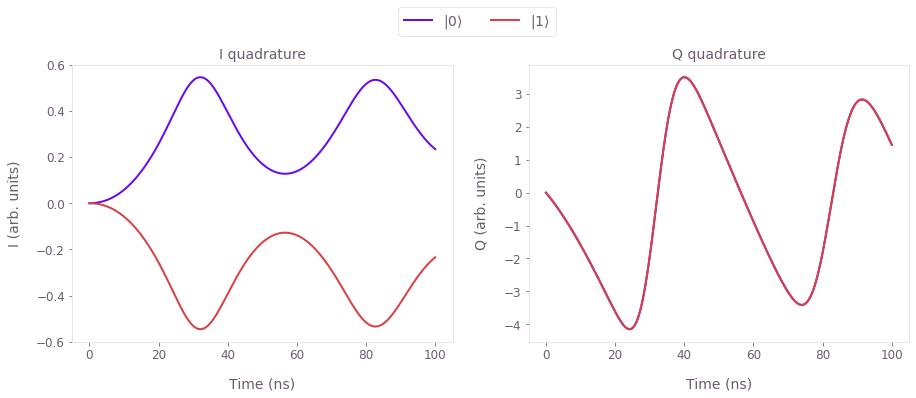

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

times = sample_times * 1e9
I_quadratures = np.real_if_close(result["output"]["I"]["value"])
Q_quadratures = np.real_if_close(result["output"]["Q"]["value"])

axs[0].set_title("I quadrature")
axs[0].plot(times, I_quadratures[0], label=r"$|0\rangle$")
axs[0].plot(times, I_quadratures[1], label=r"$|1\rangle$")
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("I (arb. units)")

axs[1].set_title("Q quadrature")
axs[1].plot(times, Q_quadratures[0], label=r"$|0\rangle$")
axs[1].plot(times, Q_quadratures[1], label=r"$|1\rangle$")
axs[1].set_xlabel("Time (ns)")
axs[1].set_ylabel("Q (arb. units)")


hs, ls = axs[0].get_legend_handles_labels()
fig.legend(handles=hs, labels=ls, loc="center", bbox_to_anchor=(0.5, 1.0), ncol=2)

plt.show()